In [1]:
import numpy as np
import pandas
import copy
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from sklearn.metrics import balanced_accuracy_score, accuracy_score,confusion_matrix , classification_report
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from efficientnet_pytorch import EfficientNet

import sys  
sys.path.insert(0, './myCode')
from PLModel import PLModel
from CustomDataset import TotalDataset
from utils import loadModelCheckpoint

/data/cino/conda/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/data/cino/conda/anaconda3/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
def showImage(image, isTensor = False):
    if isTensor:
        plt.imshow(image.permute(1, 2, 0), interpolation='nearest', aspect='equal')
    else:
        plt.imshow(image, interpolation='nearest', aspect='equal')
    plt.show()
    
def showLabel(label, prediction = False):
    if prediction:
        print("(Output della rete) La malattia è: " + labelName[label])
    else:
        print("La malattia è: " + labelName[label])
    
def showExample(example, isTensor = False):
    showLabel(example[1])
    showImage(example[0], isTensor)
    
def showLatent(label):
    print(label.size)

In [28]:
def verify_accuracy(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, labelsName: list = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC", "SCC"]) -> float:
    """
    Verifies the accuracy of the given model on the provided dataloader.

    Args:
    - model: The PyTorch model to evaluate.
    - dataloader: The DataLoader providing the dataset.
    -labelsName(opt): List of string of class labels

    Returns:
    - bal_acc: The balanced accuracy of the model.
    """
    with torch.no_grad():
        model.to(device)
        predictions = []
        truth = []

        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            predictions.extend(predicted.cpu().numpy())
            truth.extend(labels.cpu().numpy())

        acc = accuracy_score(truth, predictions) * 100
        print(f'Accuracy of the network {model.name}: {acc:.2f} %')

        truth = np.array(truth)
        predictions = np.array(predictions)
        
        bal_acc = balanced_accuracy_score(truth, predictions) * 100
        print(f'Balanced accuracy of the network {model.name}: {bal_acc:.2f} %')
        
        cm = confusion_matrix(truth, predictions)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labelsName, yticklabels=labelsName)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix for {model.name}')
        plt.show()
        print(classification_report(truth, predictions, target_names=labelsName))

        return bal_acc

In [4]:
def plot_image_grid(images, ncols=None, cmap='gray'):
    '''Plot a grid of images'''
    if not ncols:
        factors = [i for i in range(1, len(images)+1) if len(images) % i == 0]
        ncols = factors[len(factors) // 2] if len(factors) else len(images) // 4 + 1
    nrows = int(len(images) / ncols) + int(len(images) % ncols)
    imgs = [images[i] if len(images) > i else None for i in range(nrows * ncols)]
    f, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 2*nrows))
    axes = axes.flatten()[:len(imgs)]
    for img, ax in zip(imgs, axes.flatten()): 
        if np.any(img):
            if len(img.shape) > 2 and img.shape[2] == 1:
                img = img.squeeze()
            ax.axis('off')
            ax.imshow(img, cmap=cmap)

In [5]:
IMAGE_SIZE = 224
gpus = [0]
BATCH_SIZE = 16 * len(gpus)
batches = round(512 / BATCH_SIZE)

In [6]:
skinDataset = []
labelName = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC", "SCC"]

#Reading the labels
df = pandas.read_csv("DataFrames/label.csv")
#shuffling the dataframe
df = shuffle(df, random_state=1234).reset_index(drop=True)

In [7]:
#calculate frequencies to use weighted crossentropy
total = df[labelName].sum().sum()
frequencies = [df.MEL.sum(), df.NV.sum(), df.BCC.sum(), df.AK.sum(), df.BKL.sum(), df.DF.sum(), df.VASC.sum(), df.SCC.sum()] / total
w = 1. / frequencies
w = w / w.sum()
w

array([0.01864082, 0.00654709, 0.02536677, 0.09722467, 0.03212416,
       0.35269368, 0.33317703, 0.13422578])

In [8]:
#defining image size per model
imageSizePerCNN = {
    "Resnext50" : 600,
    "Resnet152" : 600,
    "EfficientNetB7": 600,
    "EfficientNetB6": 528,
    "EfficientNetB5": 456,
    "EfficientNetB4": 380,
}

In [9]:
#defining batch size per model (to be sure that it fits in memory)
imagePerBatch = {
    "Resnext50" : 16,
    "Resnet152" : 16,
    "EfficientNetB7": 4,
    "EfficientNetB6": 8,
    "EfficientNetB5": 16,
    "EfficientNetB4": 32,
}

# Create Dataloader

In [10]:
dataset = TotalDataset(df)
dataset_augmentation = TotalDataset(df, aug=True)

## Models pythorch Lightning

In [11]:
def makePrediction(image, Model, label = False, latent = False, o = True):
    Model.to('cpu')
    #Predict with the NN
    output = Model(image.unsqueeze(0))
    output = np.array(output.detach())
    if o:
        showLabel(np.argmax(output), prediction = True)
    if latent:
        showLatent(output)

In [12]:
loss = nn.CrossEntropyLoss(weight = torch.tensor(w).type(torch.FloatTensor) )
lr_monitor = LearningRateMonitor(logging_interval='step')
num_epochs = 100

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Models = []

cuda


In [14]:
model = PLModel('EfficientNetB4', EfficientNet.from_pretrained('efficientnet-b4', num_classes=8), loss = loss)
Models.append(model)

Loaded pretrained weights for efficientnet-b4


In [15]:
model = PLModel('EfficientNetB5', EfficientNet.from_pretrained('efficientnet-b5', num_classes=8), loss = loss)
Models.append(model)

Loaded pretrained weights for efficientnet-b5


In [16]:
model = PLModel('EfficientNetB6', EfficientNet.from_pretrained('efficientnet-b6', num_classes=8), loss = loss)
Models.append(model)

Loaded pretrained weights for efficientnet-b6


In [17]:
resnext = torch.hub.load('pytorch/vision:v0.9.0', 'resnext50_32x4d', pretrained=True)
num_f = resnext.fc.in_features
resnext.fc = nn.Linear(num_f, 8)
Models.append(PLModel('Resnext50', resnext, loss = loss))

Using cache found in /data/cino/.cache/torch/hub/pytorch_vision_v0.9.0


In [18]:
resnext = torch.hub.load('pytorch/vision:v0.9.0', 'resnet152', pretrained=True)
num_f = resnext.fc.in_features
resnext.fc = nn.Linear(num_f, 8)
Models.append(PLModel('Resnet152', resnext, loss = loss))

Using cache found in /data/cino/.cache/torch/hub/pytorch_vision_v0.9.0


In [ ]:
for model in Models:
    dataset = TotalDataset(df, imageSize = imageSizePerCNN[model.name])
    
    kFolds = dataset.getKFolds()
    
    for k, (trainingDataset, validationDataset) in enumerate(kFolds):
        
        wd = 0
        
        modelTrain = PLModel(model.name + "_"+ str(k) + "Fold", copy.deepcopy(model.model), loss = model.loss, wd = wd)
        
        checkpoint_callback = ModelCheckpoint(dirpath="checkpoints/" + modelTrain.name + "/", save_top_k=1, monitor="valLoss")
        
        dataloaderTrain = DataLoader(dataset=trainingDataset, batch_size=imagePerBatch[model.name] , shuffle=False, num_workers=8 )
        dataloaderVal = DataLoader(dataset=validationDataset, batch_size=imagePerBatch[model.name] , shuffle=False, num_workers=8 )
    
        print("Training network " + modelTrain.name)
    
        trainer = pl.Trainer()

        tb_logger = pl_loggers.TensorBoardLogger('logs/', name =modelTrain.writer )

        trainer = pl.Trainer(gpus=gpus, accelerator='cuda', max_epochs=num_epochs,
                            accumulate_grad_batches = batches,
                             logger=tb_logger, callbacks=[lr_monitor, checkpoint_callback]
                            )
        trainer.fit(modelTrain, dataloaderTrain, dataloaderVal)
        modelTrain.eval()
        verifyAccuracy(modelTrain, dataloaderVal, test=False)                                

In [19]:
models_name = [model.name for model in Models ]
df_acc = pandas.DataFrame(columns = ['Fold0', 'Fold1', 'Fold2','Fold3','Fold4'], index = models_name)
df_acc

,Fold0,Fold1,Fold2,Fold3,Fold4
EfficientNetB4,NaN,NaN,NaN,NaN,NaN
EfficientNetB5,NaN,NaN,NaN,NaN,NaN
EfficientNetB6,NaN,NaN,NaN,NaN,NaN
Resnext50,NaN,NaN,NaN,NaN,NaN
Resnet152,NaN,NaN,NaN,NaN,NaN


EfficientNetB4
Unable to load pytorch lightning, trying without loss.weightError(s) in loading state_dict for PLModel:
	Missing key(s) in state_dict: "loss.weight". 
Model Loaded
Accuracy of the network EfficientNetB4: 88.04 %
Balanced accuracy of the network EfficientNetB4: 85.25 %


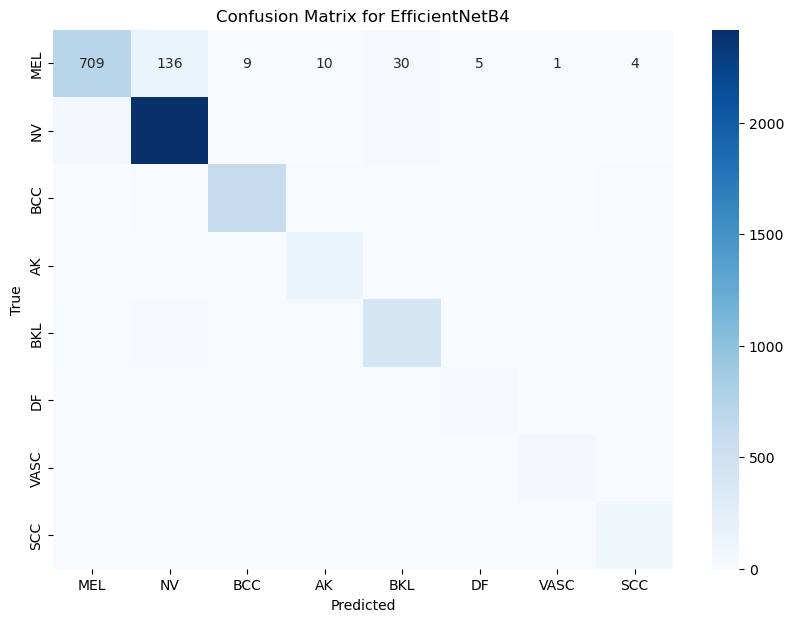

              precision    recall  f1-score   support

         MEL       0.85      0.78      0.81       904
          NV       0.92      0.94      0.93      2575
         BCC       0.92      0.90      0.91       665
          AK       0.68      0.78      0.72       173
         BKL       0.79      0.79      0.79       525
          DF       0.72      0.85      0.78        48
        VASC       0.89      1.00      0.94        51
         SCC       0.75      0.78      0.77       126

    accuracy                           0.88      5067
   macro avg       0.82      0.85      0.83      5067
weighted avg       0.88      0.88      0.88      5067

EfficientNetB4
Unable to load pytorch lightning, trying without loss.weightError(s) in loading state_dict for PLModel:
	Missing key(s) in state_dict: "loss.weight". 
Model Loaded
Accuracy of the network EfficientNetB4: 89.50 %
Balanced accuracy of the network EfficientNetB4: 86.97 %


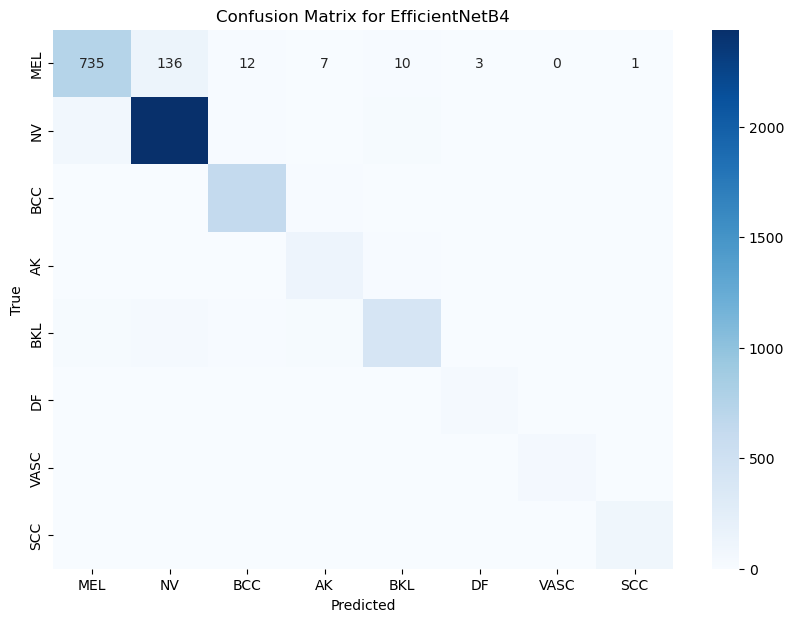

              precision    recall  f1-score   support

         MEL       0.86      0.81      0.83       904
          NV       0.93      0.95      0.94      2575
         BCC       0.91      0.93      0.92       665
          AK       0.71      0.77      0.74       173
         BKL       0.88      0.78      0.83       525
          DF       0.76      0.94      0.84        48
        VASC       0.81      0.98      0.88        51
         SCC       0.83      0.79      0.81       126

    accuracy                           0.90      5067
   macro avg       0.84      0.87      0.85      5067
weighted avg       0.90      0.90      0.89      5067

EfficientNetB4
Unable to load pytorch lightning, trying without loss.weightError(s) in loading state_dict for PLModel:
	Missing key(s) in state_dict: "loss.weight". 
Model Loaded
Accuracy of the network EfficientNetB4: 88.10 %
Balanced accuracy of the network EfficientNetB4: 82.01 %


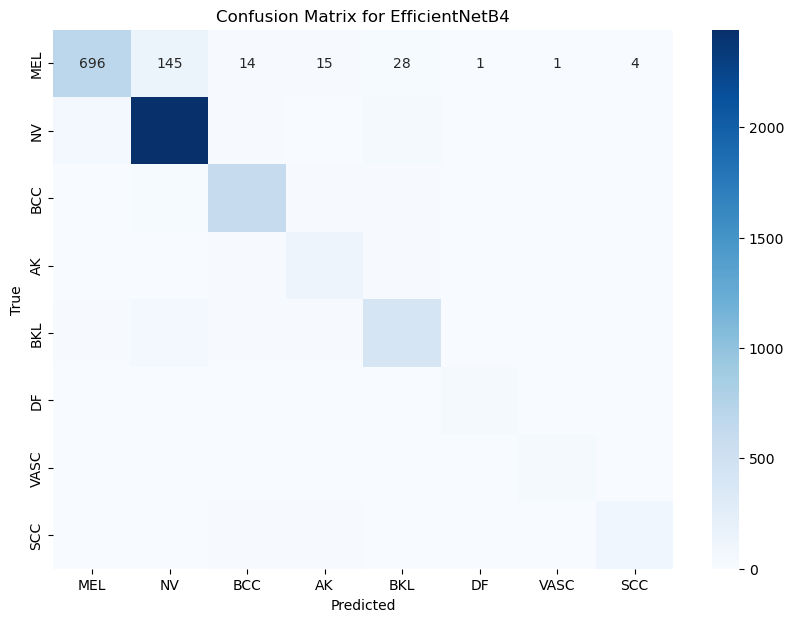

              precision    recall  f1-score   support

         MEL       0.87      0.77      0.82       904
          NV       0.91      0.95      0.93      2575
         BCC       0.89      0.91      0.90       665
          AK       0.70      0.77      0.73       173
         BKL       0.81      0.79      0.80       525
          DF       0.80      0.81      0.80        48
        VASC       0.89      0.82      0.86        51
         SCC       0.79      0.74      0.77       126

    accuracy                           0.88      5067
   macro avg       0.83      0.82      0.83      5067
weighted avg       0.88      0.88      0.88      5067

EfficientNetB4
Unable to load pytorch lightning, trying without loss.weightError(s) in loading state_dict for PLModel:
	Missing key(s) in state_dict: "loss.weight". 
Model Loaded
Accuracy of the network EfficientNetB4: 89.62 %
Balanced accuracy of the network EfficientNetB4: 86.54 %


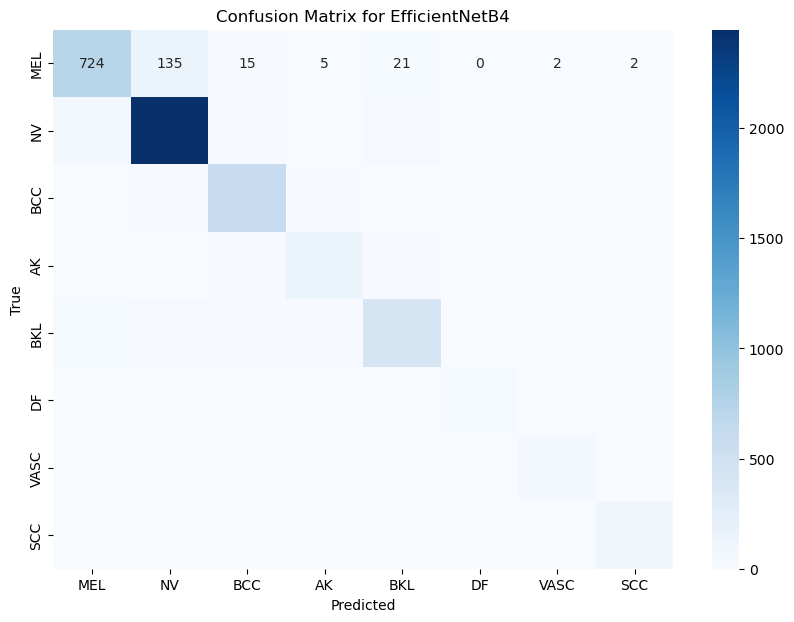

              precision    recall  f1-score   support

         MEL       0.86      0.80      0.83       904
          NV       0.93      0.95      0.94      2575
         BCC       0.90      0.93      0.91       665
          AK       0.77      0.77      0.77       173
         BKL       0.84      0.82      0.83       525
          DF       0.88      0.90      0.89        48
        VASC       0.81      0.98      0.88        51
         SCC       0.84      0.78      0.81       126

    accuracy                           0.90      5067
   macro avg       0.85      0.87      0.86      5067
weighted avg       0.90      0.90      0.90      5067

EfficientNetB4
Unable to load pytorch lightning, trying without loss.weightError(s) in loading state_dict for PLModel:
	Missing key(s) in state_dict: "loss.weight". 
Model Loaded
Accuracy of the network EfficientNetB4: 89.48 %
Balanced accuracy of the network EfficientNetB4: 86.04 %


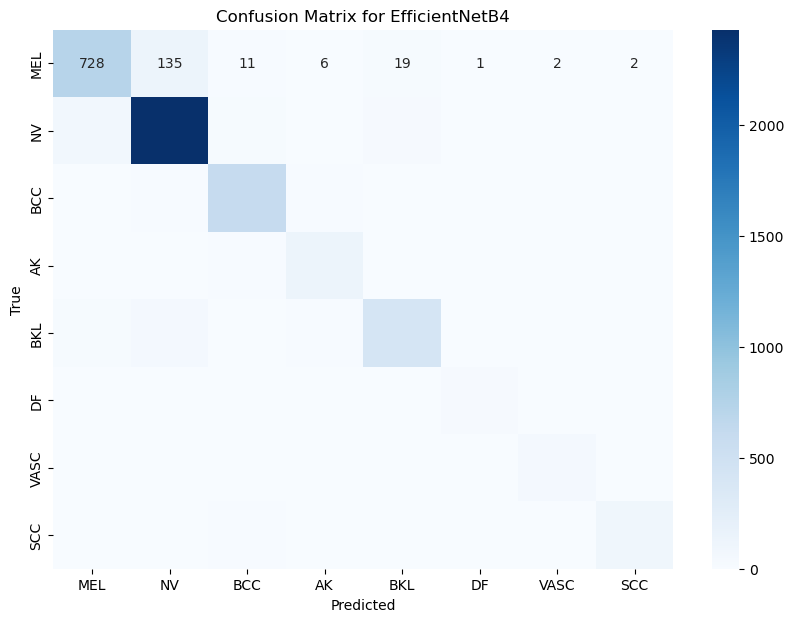

              precision    recall  f1-score   support

         MEL       0.86      0.81      0.83       904
          NV       0.92      0.94      0.93      2575
         BCC       0.91      0.93      0.92       663
          AK       0.79      0.82      0.81       173
         BKL       0.87      0.81      0.84       524
          DF       0.79      0.79      0.79        47
        VASC       0.86      1.00      0.92        49
         SCC       0.84      0.78      0.81       124

    accuracy                           0.89      5059
   macro avg       0.85      0.86      0.86      5059
weighted avg       0.89      0.89      0.89      5059

EfficientNetB5
Unable to load pytorch lightning, trying without loss.weightError(s) in loading state_dict for PLModel:
	Missing key(s) in state_dict: "loss.weight". 
Model Loaded
Accuracy of the network EfficientNetB5: 87.67 %
Balanced accuracy of the network EfficientNetB5: 86.37 %


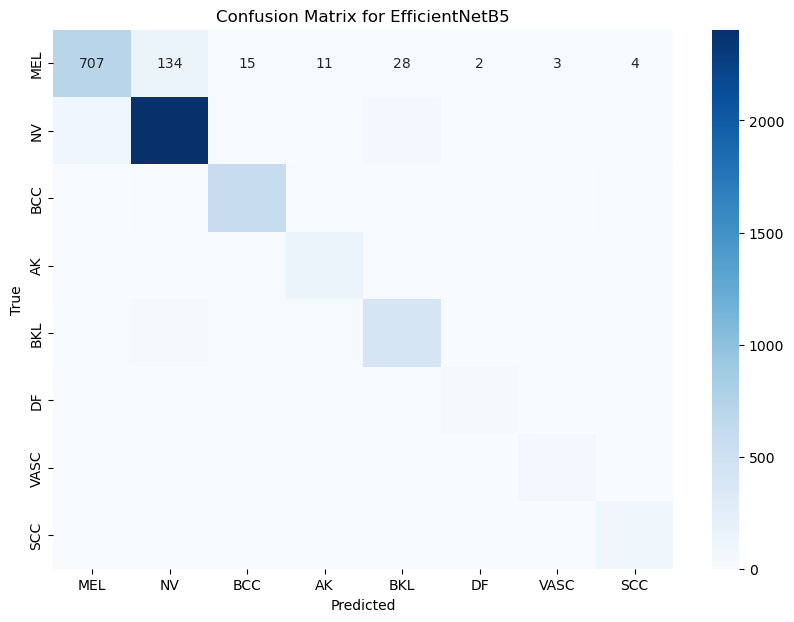

              precision    recall  f1-score   support

         MEL       0.86      0.78      0.82       904
          NV       0.92      0.93      0.93      2575
         BCC       0.90      0.88      0.89       665
          AK       0.64      0.80      0.71       173
         BKL       0.80      0.78      0.79       525
          DF       0.72      0.96      0.82        48
        VASC       0.86      0.96      0.91        51
         SCC       0.76      0.82      0.79       126

    accuracy                           0.88      5067
   macro avg       0.81      0.86      0.83      5067
weighted avg       0.88      0.88      0.88      5067

EfficientNetB5
Unable to load pytorch lightning, trying without loss.weightError(s) in loading state_dict for PLModel:
	Missing key(s) in state_dict: "loss.weight". 
Model Loaded
Accuracy of the network EfficientNetB5: 88.79 %
Balanced accuracy of the network EfficientNetB5: 86.22 %


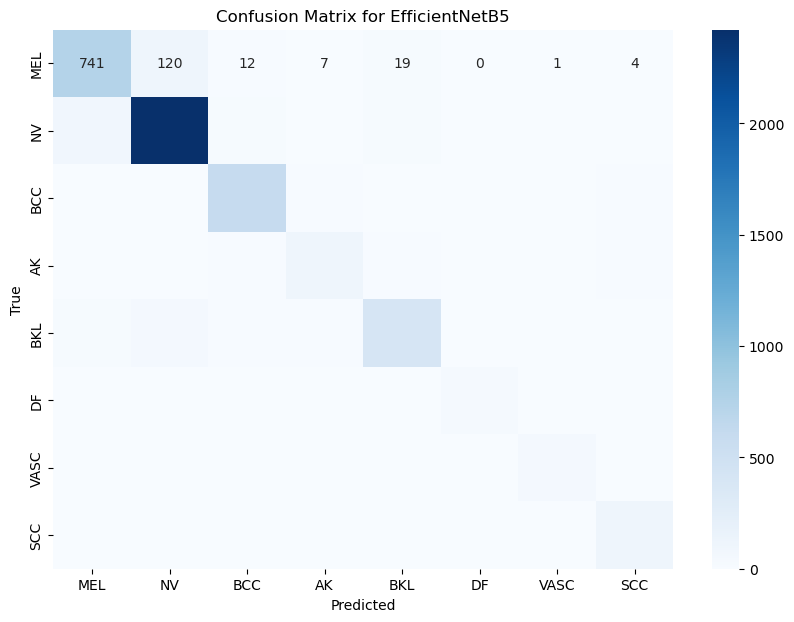

              precision    recall  f1-score   support

         MEL       0.84      0.82      0.83       904
          NV       0.93      0.94      0.93      2575
         BCC       0.90      0.91      0.91       665
          AK       0.73      0.69      0.71       173
         BKL       0.85      0.78      0.81       525
          DF       0.81      0.92      0.86        48
        VASC       0.89      1.00      0.94        51
         SCC       0.73      0.83      0.78       126

    accuracy                           0.89      5067
   macro avg       0.84      0.86      0.85      5067
weighted avg       0.89      0.89      0.89      5067

EfficientNetB5
Unable to load pytorch lightning, trying without loss.weightError(s) in loading state_dict for PLModel:
	Missing key(s) in state_dict: "loss.weight". 
Model Loaded
Accuracy of the network EfficientNetB5: 88.42 %
Balanced accuracy of the network EfficientNetB5: 83.05 %


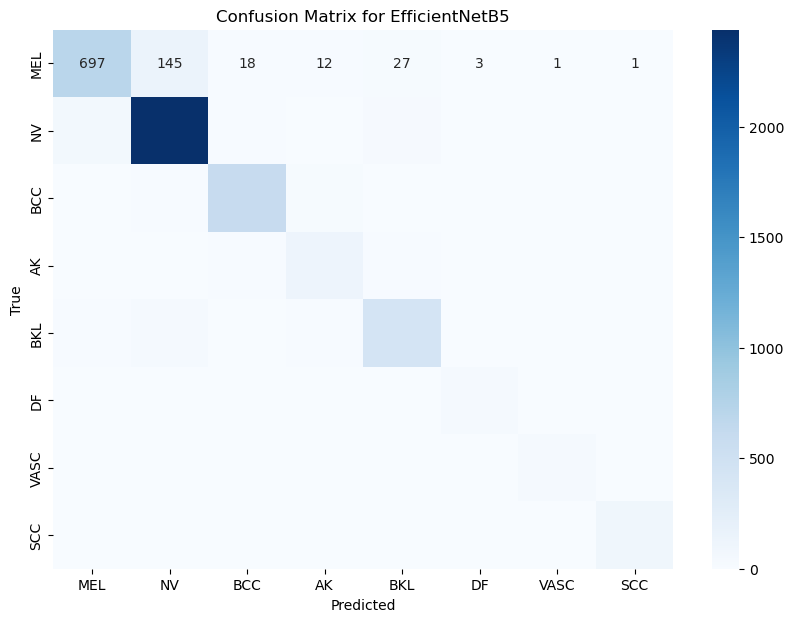

              precision    recall  f1-score   support

         MEL       0.88      0.77      0.82       904
          NV       0.92      0.95      0.93      2575
         BCC       0.90      0.91      0.90       665
          AK       0.68      0.76      0.72       173
         BKL       0.82      0.82      0.82       525
          DF       0.68      0.83      0.75        48
        VASC       0.86      0.82      0.84        51
         SCC       0.83      0.79      0.81       126

    accuracy                           0.88      5067
   macro avg       0.82      0.83      0.82      5067
weighted avg       0.88      0.88      0.88      5067

EfficientNetB5
Unable to load pytorch lightning, trying without loss.weightError(s) in loading state_dict for PLModel:
	Missing key(s) in state_dict: "loss.weight". 
Model Loaded
Accuracy of the network EfficientNetB5: 88.83 %
Balanced accuracy of the network EfficientNetB5: 85.88 %


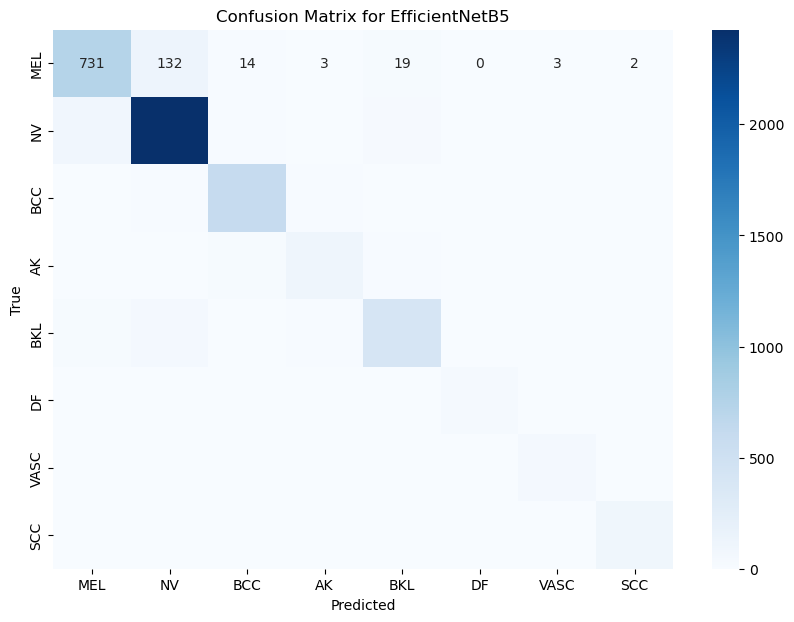

              precision    recall  f1-score   support

         MEL       0.85      0.81      0.83       904
          NV       0.92      0.94      0.93      2575
         BCC       0.90      0.92      0.91       665
          AK       0.74      0.71      0.73       173
         BKL       0.85      0.79      0.82       525
          DF       0.74      0.94      0.83        48
        VASC       0.77      0.96      0.85        51
         SCC       0.82      0.80      0.81       126

    accuracy                           0.89      5067
   macro avg       0.82      0.86      0.84      5067
weighted avg       0.89      0.89      0.89      5067

EfficientNetB5
Unable to load pytorch lightning, trying without loss.weightError(s) in loading state_dict for PLModel:
	Missing key(s) in state_dict: "loss.weight". 
Model Loaded
Accuracy of the network EfficientNetB5: 88.73 %
Balanced accuracy of the network EfficientNetB5: 83.05 %


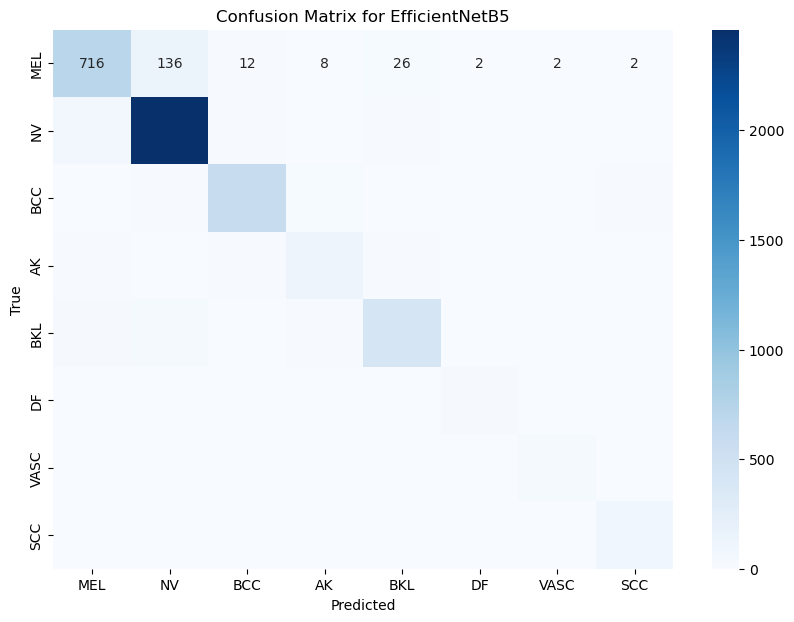

              precision    recall  f1-score   support

         MEL       0.86      0.79      0.82       904
          NV       0.92      0.95      0.94      2575
         BCC       0.91      0.90      0.91       663
          AK       0.68      0.73      0.71       173
         BKL       0.86      0.79      0.82       524
          DF       0.79      0.81      0.80        47
        VASC       0.85      0.94      0.89        49
         SCC       0.76      0.73      0.74       124

    accuracy                           0.89      5059
   macro avg       0.83      0.83      0.83      5059
weighted avg       0.89      0.89      0.89      5059

EfficientNetB6
Unable to load pytorch lightning, trying without loss.weightError(s) in loading state_dict for PLModel:
	Missing key(s) in state_dict: "loss.weight". 
Model Loaded
Accuracy of the network EfficientNetB6: 85.89 %
Balanced accuracy of the network EfficientNetB6: 84.19 %


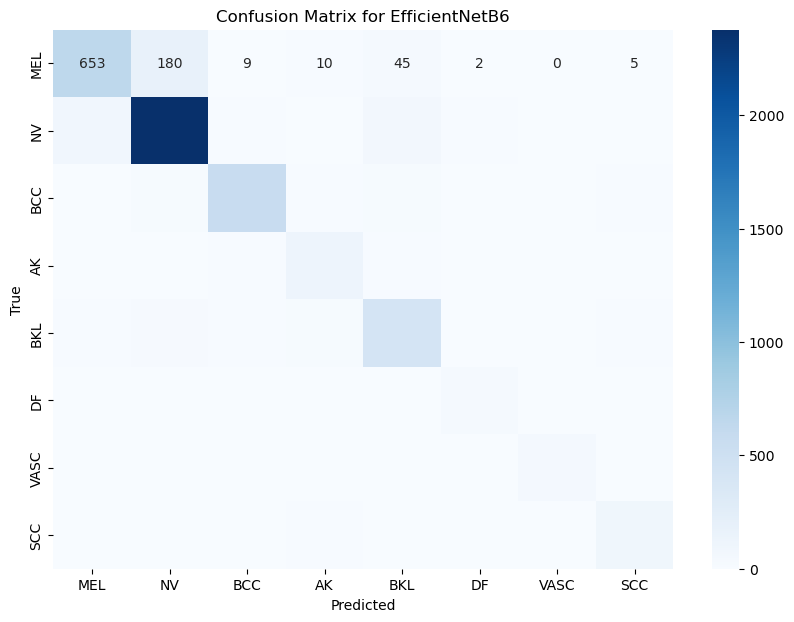

              precision    recall  f1-score   support

         MEL       0.85      0.72      0.78       904
          NV       0.91      0.92      0.92      2575
         BCC       0.91      0.86      0.89       665
          AK       0.68      0.75      0.71       173
         BKL       0.73      0.81      0.77       525
          DF       0.64      0.90      0.75        48
        VASC       0.88      0.98      0.93        51
         SCC       0.67      0.79      0.72       126

    accuracy                           0.86      5067
   macro avg       0.78      0.84      0.81      5067
weighted avg       0.86      0.86      0.86      5067

EfficientNetB6
Unable to load pytorch lightning, trying without loss.weightError(s) in loading state_dict for PLModel:
	Missing key(s) in state_dict: "loss.weight". 
Model Loaded
Accuracy of the network EfficientNetB6: 87.53 %
Balanced accuracy of the network EfficientNetB6: 83.77 %


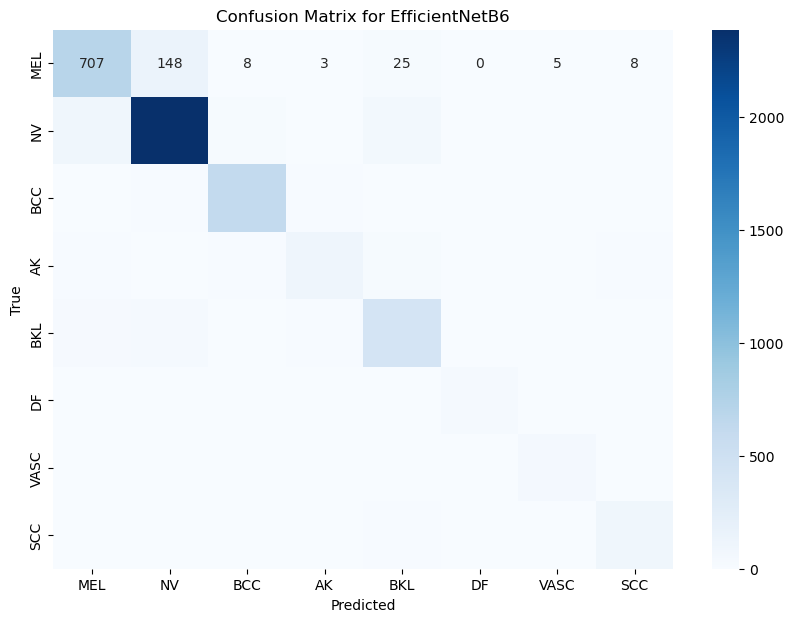

              precision    recall  f1-score   support

         MEL       0.83      0.78      0.81       904
          NV       0.92      0.93      0.92      2575
         BCC       0.92      0.93      0.92       665
          AK       0.72      0.64      0.68       173
         BKL       0.77      0.81      0.79       525
          DF       0.85      0.83      0.84        48
        VASC       0.76      1.00      0.86        51
         SCC       0.73      0.79      0.76       126

    accuracy                           0.88      5067
   macro avg       0.81      0.84      0.82      5067
weighted avg       0.88      0.88      0.87      5067

EfficientNetB6
Unable to load pytorch lightning, trying without loss.weightError(s) in loading state_dict for PLModel:
	Missing key(s) in state_dict: "loss.weight". 
Model Loaded
Accuracy of the network EfficientNetB6: 87.39 %
Balanced accuracy of the network EfficientNetB6: 83.13 %


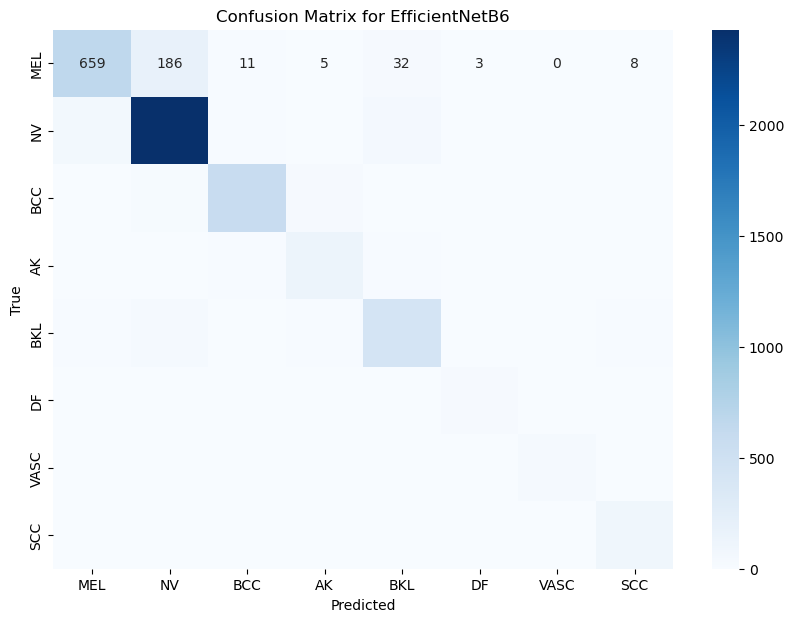

              precision    recall  f1-score   support

         MEL       0.88      0.73      0.80       904
          NV       0.90      0.94      0.92      2575
         BCC       0.92      0.87      0.90       665
          AK       0.68      0.82      0.74       173
         BKL       0.80      0.83      0.81       525
          DF       0.69      0.77      0.73        48
        VASC       0.80      0.88      0.84        51
         SCC       0.71      0.80      0.75       126

    accuracy                           0.87      5067
   macro avg       0.80      0.83      0.81      5067
weighted avg       0.88      0.87      0.87      5067

EfficientNetB6
Unable to load pytorch lightning, trying without loss.weightError(s) in loading state_dict for PLModel:
	Missing key(s) in state_dict: "loss.weight". 
Model Loaded
Accuracy of the network EfficientNetB6: 87.78 %
Balanced accuracy of the network EfficientNetB6: 84.16 %


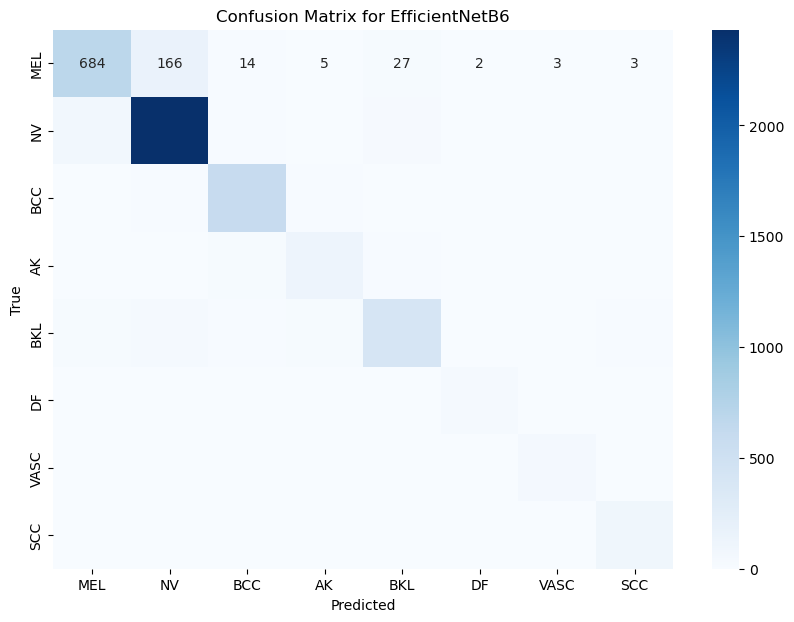

              precision    recall  f1-score   support

         MEL       0.85      0.76      0.80       904
          NV       0.91      0.94      0.93      2575
         BCC       0.89      0.90      0.90       665
          AK       0.72      0.76      0.74       173
         BKL       0.83      0.78      0.81       525
          DF       0.77      0.83      0.80        48
        VASC       0.80      0.96      0.88        51
         SCC       0.79      0.79      0.79       126

    accuracy                           0.88      5067
   macro avg       0.82      0.84      0.83      5067
weighted avg       0.88      0.88      0.88      5067

EfficientNetB6
Unable to load pytorch lightning, trying without loss.weightError(s) in loading state_dict for PLModel:
	Missing key(s) in state_dict: "loss.weight". 
Model Loaded
Accuracy of the network EfficientNetB6: 86.30 %
Balanced accuracy of the network EfficientNetB6: 81.86 %


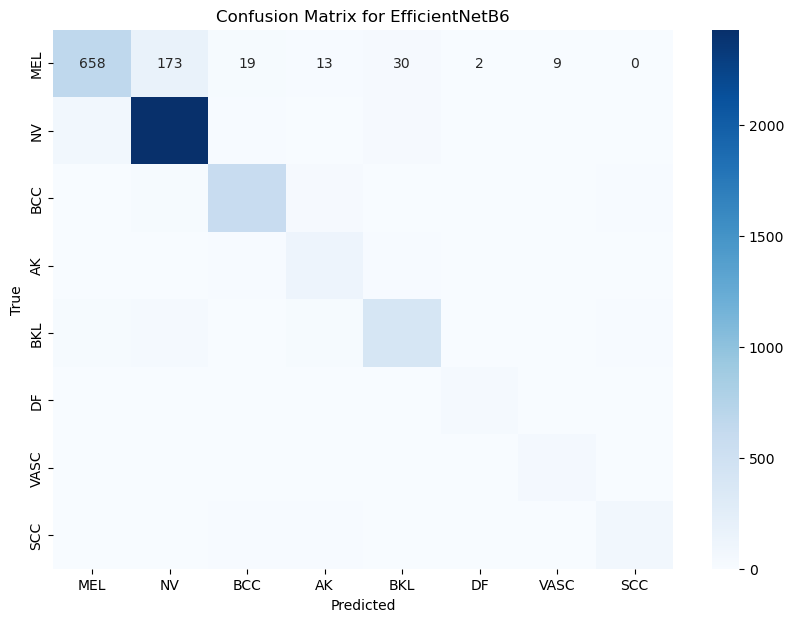

              precision    recall  f1-score   support

         MEL       0.84      0.73      0.78       904
          NV       0.91      0.94      0.92      2575
         BCC       0.88      0.88      0.88       663
          AK       0.60      0.72      0.65       173
         BKL       0.81      0.77      0.79       524
          DF       0.75      0.85      0.80        47
        VASC       0.70      1.00      0.82        49
         SCC       0.71      0.66      0.68       124

    accuracy                           0.86      5059
   macro avg       0.78      0.82      0.79      5059
weighted avg       0.86      0.86      0.86      5059

Resnext50
Unable to load pytorch lightning, trying without loss.weightError(s) in loading state_dict for PLModel:
	Missing key(s) in state_dict: "loss.weight". 
Model Loaded
Accuracy of the network Resnext50: 84.94 %
Balanced accuracy of the network Resnext50: 81.90 %


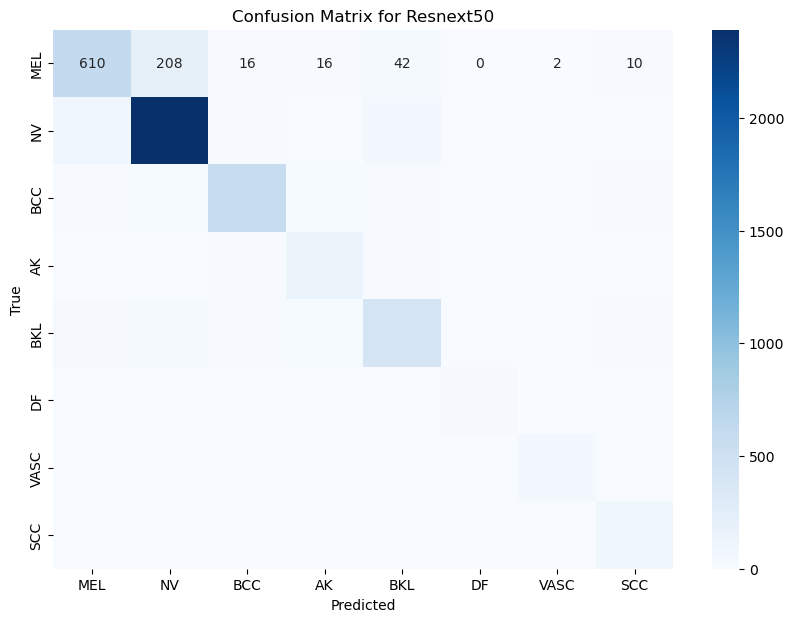

              precision    recall  f1-score   support

         MEL       0.81      0.67      0.74       904
          NV       0.90      0.93      0.91      2575
         BCC       0.89      0.87      0.88       665
          AK       0.64      0.78      0.70       173
         BKL       0.73      0.77      0.75       525
          DF       0.86      0.77      0.81        48
        VASC       0.91      0.98      0.94        51
         SCC       0.72      0.78      0.75       126

    accuracy                           0.85      5067
   macro avg       0.81      0.82      0.81      5067
weighted avg       0.85      0.85      0.85      5067

Resnext50
Unable to load pytorch lightning, trying without loss.weightError(s) in loading state_dict for PLModel:
	Missing key(s) in state_dict: "loss.weight". 
Model Loaded
Accuracy of the network Resnext50: 84.41 %
Balanced accuracy of the network Resnext50: 81.60 %


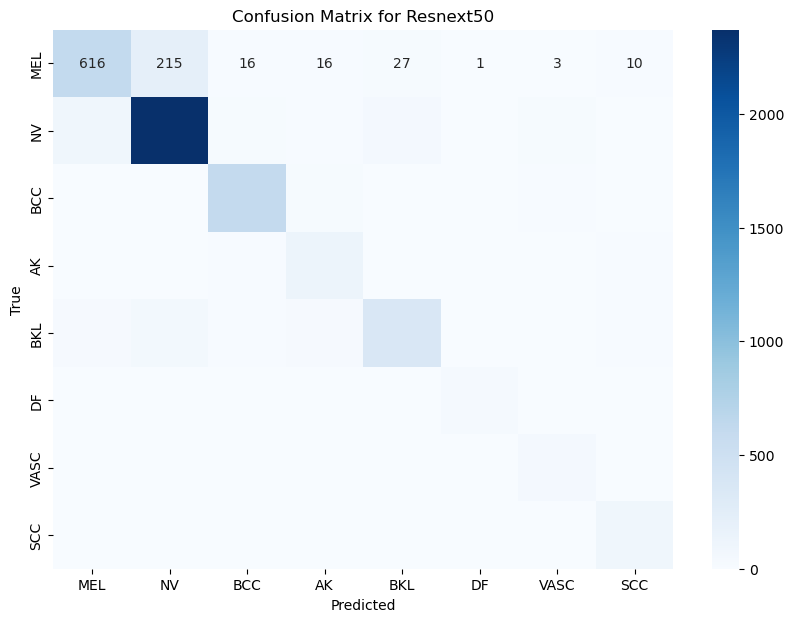

              precision    recall  f1-score   support

         MEL       0.81      0.68      0.74       904
          NV       0.89      0.92      0.91      2575
         BCC       0.89      0.91      0.90       665
          AK       0.59      0.77      0.67       173
         BKL       0.79      0.70      0.74       525
          DF       0.80      0.81      0.80        48
        VASC       0.58      0.98      0.73        51
         SCC       0.69      0.75      0.72       126

    accuracy                           0.84      5067
   macro avg       0.75      0.82      0.78      5067
weighted avg       0.85      0.84      0.84      5067

Resnext50
Unable to load pytorch lightning, trying without loss.weightError(s) in loading state_dict for PLModel:
	Missing key(s) in state_dict: "loss.weight". 
Model Loaded
Accuracy of the network Resnext50: 85.83 %
Balanced accuracy of the network Resnext50: 80.23 %


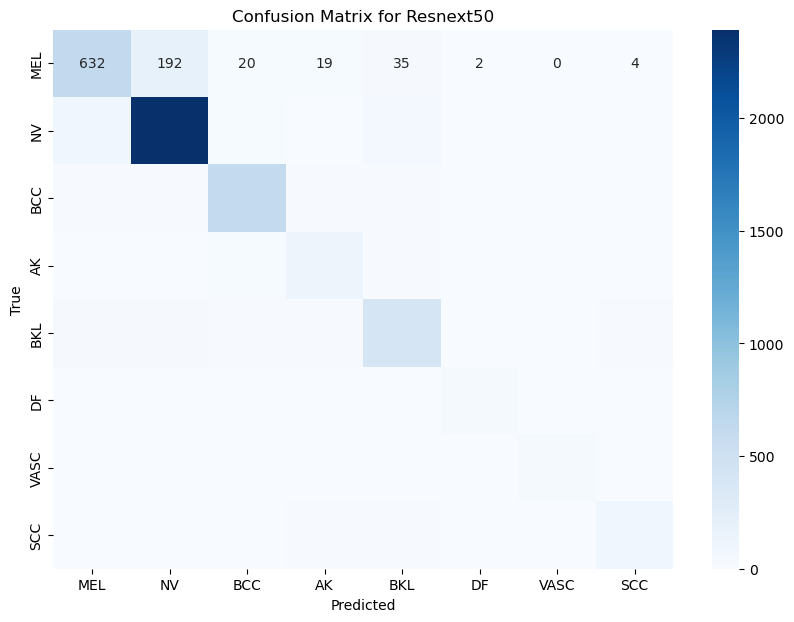

              precision    recall  f1-score   support

         MEL       0.82      0.70      0.75       904
          NV       0.91      0.93      0.92      2575
         BCC       0.87      0.92      0.89       665
          AK       0.66      0.73      0.69       173
         BKL       0.77      0.79      0.78       525
          DF       0.71      0.81      0.76        48
        VASC       1.00      0.82      0.90        51
         SCC       0.71      0.71      0.71       126

    accuracy                           0.86      5067
   macro avg       0.81      0.80      0.80      5067
weighted avg       0.86      0.86      0.86      5067

Resnext50
Unable to load pytorch lightning, trying without loss.weightError(s) in loading state_dict for PLModel:
	Missing key(s) in state_dict: "loss.weight". 
Model Loaded
Accuracy of the network Resnext50: 85.89 %
Balanced accuracy of the network Resnext50: 80.08 %


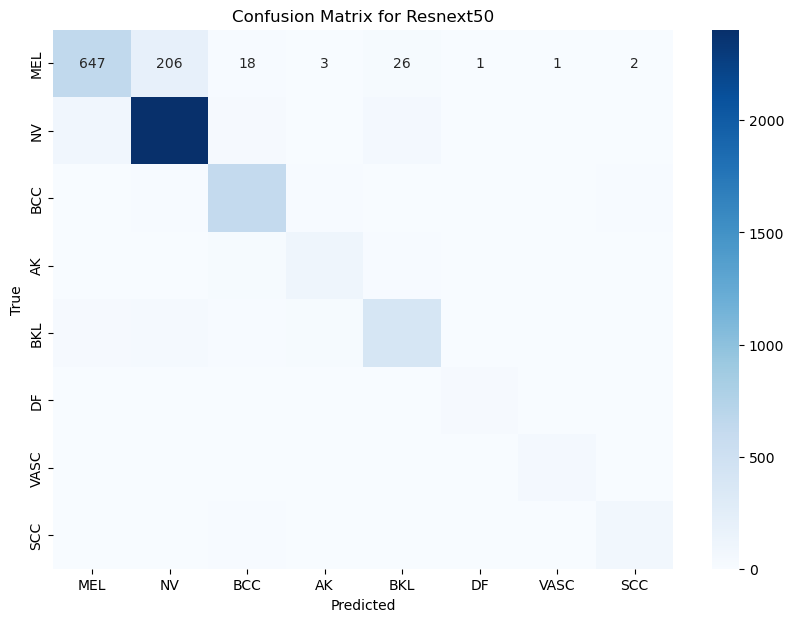

              precision    recall  f1-score   support

         MEL       0.82      0.72      0.76       904
          NV       0.90      0.93      0.91      2575
         BCC       0.85      0.92      0.89       665
          AK       0.69      0.68      0.68       173
         BKL       0.80      0.76      0.78       525
          DF       0.92      0.73      0.81        48
        VASC       0.93      1.00      0.96        51
         SCC       0.75      0.67      0.71       126

    accuracy                           0.86      5067
   macro avg       0.83      0.80      0.81      5067
weighted avg       0.86      0.86      0.86      5067

Resnext50
Unable to load pytorch lightning, trying without loss.weightError(s) in loading state_dict for PLModel:
	Missing key(s) in state_dict: "loss.weight". 
Model Loaded
Accuracy of the network Resnext50: 86.01 %
Balanced accuracy of the network Resnext50: 80.20 %


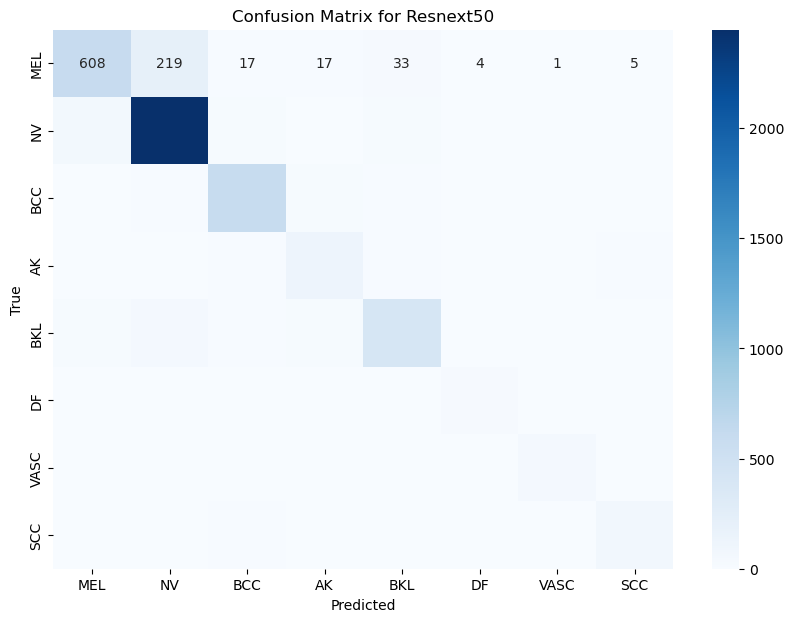

              precision    recall  f1-score   support

         MEL       0.85      0.67      0.75       904
          NV       0.89      0.95      0.92      2575
         BCC       0.87      0.91      0.89       663
          AK       0.63      0.72      0.67       173
         BKL       0.82      0.77      0.79       524
          DF       0.74      0.72      0.73        47
        VASC       0.87      0.98      0.92        49
         SCC       0.72      0.69      0.70       124

    accuracy                           0.86      5059
   macro avg       0.80      0.80      0.80      5059
weighted avg       0.86      0.86      0.86      5059

Resnet152
Unable to load pytorch lightning, trying without loss.weightError(s) in loading state_dict for PLModel:
	Missing key(s) in state_dict: "loss.weight". 
Model Loaded
Accuracy of the network Resnet152: 83.99 %
Balanced accuracy of the network Resnet152: 79.12 %


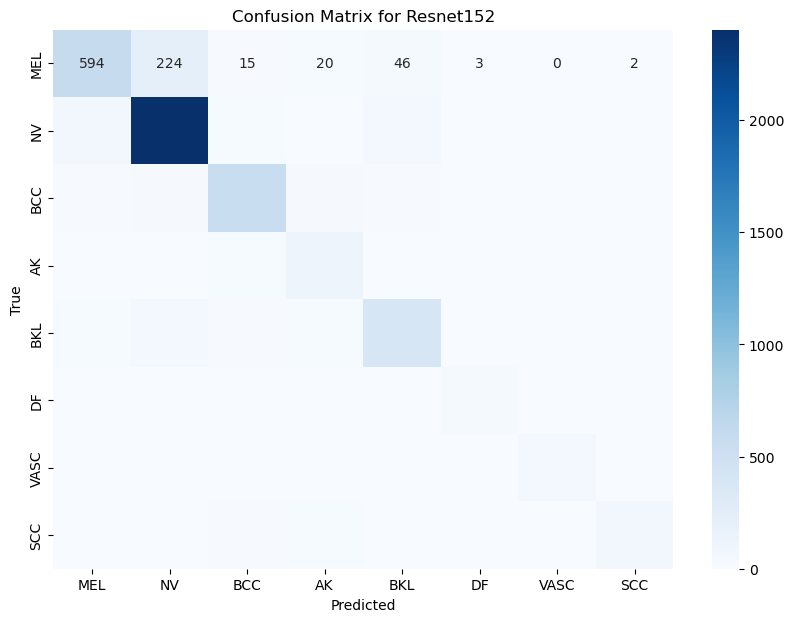

              precision    recall  f1-score   support

         MEL       0.83      0.66      0.73       904
          NV       0.88      0.93      0.91      2575
         BCC       0.86      0.85      0.86       665
          AK       0.55      0.73      0.62       173
         BKL       0.76      0.76      0.76       525
          DF       0.73      0.79      0.76        48
        VASC       0.89      0.98      0.93        51
         SCC       0.77      0.63      0.69       126

    accuracy                           0.84      5067
   macro avg       0.78      0.79      0.78      5067
weighted avg       0.84      0.84      0.84      5067

Resnet152
Unable to load pytorch lightning, trying without loss.weightError(s) in loading state_dict for PLModel:
	Missing key(s) in state_dict: "loss.weight". 
Model Loaded
Accuracy of the network Resnet152: 85.02 %
Balanced accuracy of the network Resnet152: 80.78 %


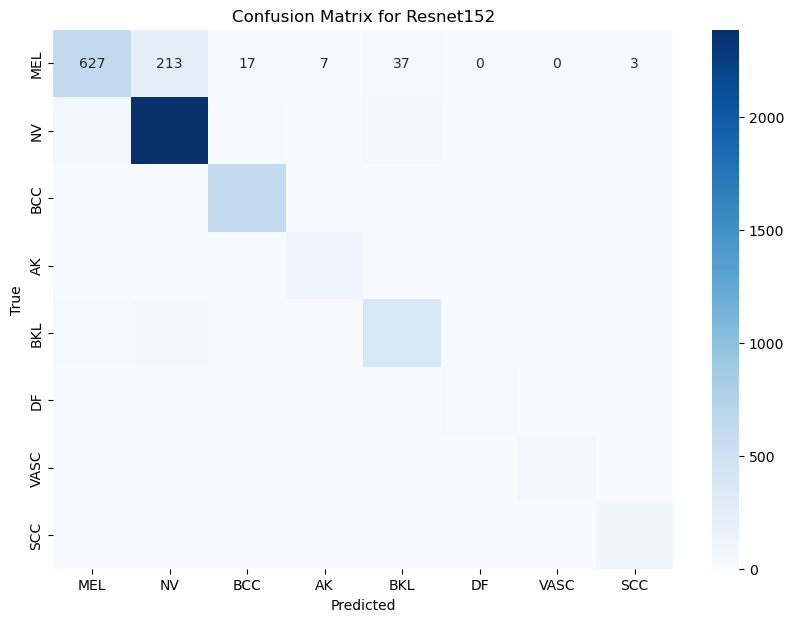

              precision    recall  f1-score   support

         MEL       0.82      0.69      0.75       904
          NV       0.89      0.93      0.91      2575
         BCC       0.87      0.92      0.89       665
          AK       0.63      0.69      0.66       173
         BKL       0.75      0.72      0.74       525
          DF       0.85      0.81      0.83        48
        VASC       0.92      0.92      0.92        51
         SCC       0.79      0.78      0.78       126

    accuracy                           0.85      5067
   macro avg       0.81      0.81      0.81      5067
weighted avg       0.85      0.85      0.85      5067

Resnet152
Unable to load pytorch lightning, trying without loss.weightError(s) in loading state_dict for PLModel:
	Missing key(s) in state_dict: "loss.weight". 
Model Loaded
Accuracy of the network Resnet152: 84.25 %
Balanced accuracy of the network Resnet152: 76.48 %


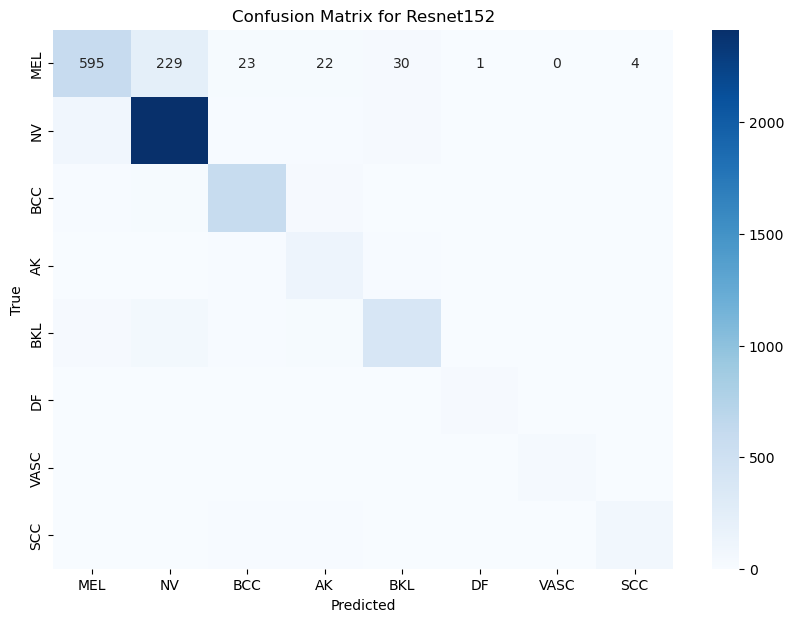

              precision    recall  f1-score   support

         MEL       0.80      0.66      0.72       904
          NV       0.88      0.94      0.91      2575
         BCC       0.87      0.89      0.88       665
          AK       0.56      0.72      0.63       173
         BKL       0.80      0.74      0.77       525
          DF       0.76      0.71      0.73        48
        VASC       0.93      0.82      0.87        51
         SCC       0.76      0.64      0.70       126

    accuracy                           0.84      5067
   macro avg       0.80      0.76      0.78      5067
weighted avg       0.84      0.84      0.84      5067

Resnet152
Unable to load pytorch lightning, trying without loss.weightError(s) in loading state_dict for PLModel:
	Missing key(s) in state_dict: "loss.weight". 
Model Loaded
Accuracy of the network Resnet152: 84.94 %
Balanced accuracy of the network Resnet152: 81.15 %


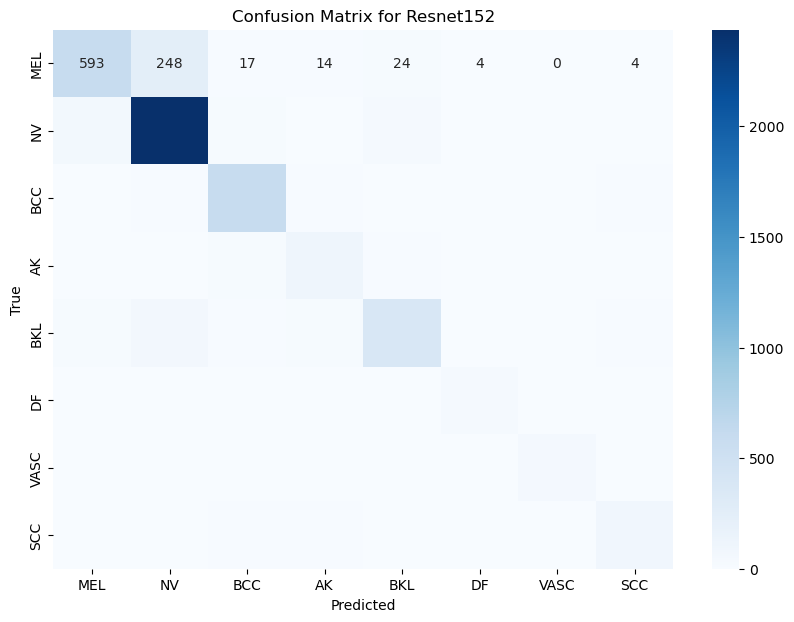

              precision    recall  f1-score   support

         MEL       0.84      0.66      0.74       904
          NV       0.88      0.95      0.91      2575
         BCC       0.87      0.89      0.88       665
          AK       0.61      0.66      0.63       173
         BKL       0.81      0.73      0.77       525
          DF       0.78      0.90      0.83        48
        VASC       0.86      1.00      0.93        51
         SCC       0.69      0.71      0.70       126

    accuracy                           0.85      5067
   macro avg       0.79      0.81      0.80      5067
weighted avg       0.85      0.85      0.85      5067

Resnet152
Unable to load pytorch lightning, trying without loss.weightError(s) in loading state_dict for PLModel:
	Missing key(s) in state_dict: "loss.weight". 
Model Loaded
Accuracy of the network Resnet152: 80.61 %
Balanced accuracy of the network Resnet152: 77.73 %


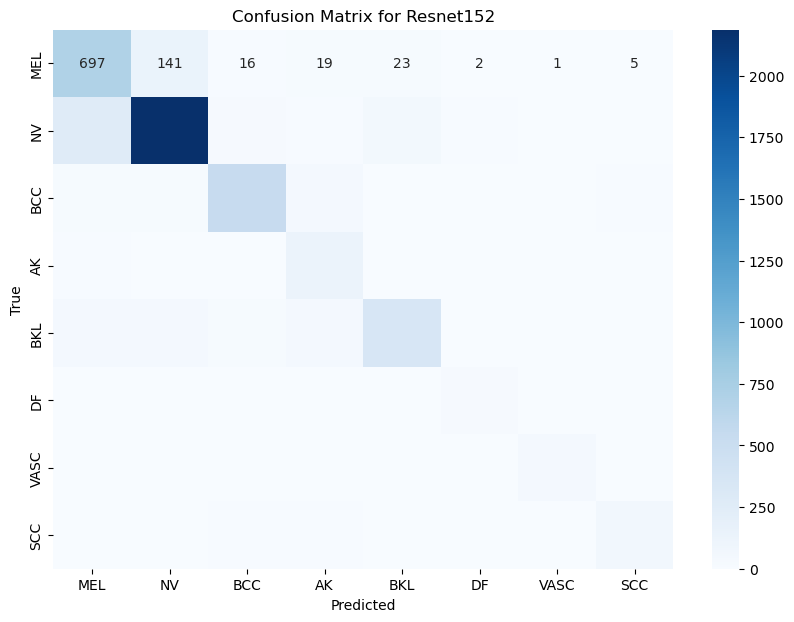

              precision    recall  f1-score   support

         MEL       0.66      0.77      0.71       904
          NV       0.91      0.85      0.88      2575
         BCC       0.86      0.82      0.84       663
          AK       0.49      0.78      0.60       173
         BKL       0.78      0.68      0.73       524
          DF       0.67      0.70      0.69        47
        VASC       0.78      1.00      0.88        49
         SCC       0.64      0.61      0.63       124

    accuracy                           0.81      5059
   macro avg       0.72      0.78      0.74      5059
weighted avg       0.82      0.81      0.81      5059



In [29]:
for model in Models:
    dataset = TotalDataset(df, imageSize = imageSizePerCNN[model.name])
    
    kFolds = dataset.getKFolds()
    
    for k, (trainingDataset, validationDataset) in enumerate(kFolds):
        print(model.name)
        mypath = 'checkpoints/' + model.name + '_' + str(k) + 'Fold'
        weights_path = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))][0]

        weights_path = mypath + "/" + weights_path

        model = loadModelCheckpoint(weights_path, model)
        
        dataloaderVal = DataLoader(dataset=validationDataset, batch_size=imagePerBatch[model.name] , shuffle=False, num_workers=8 )
        model.eval()
        acc = verify_accuracy(model, dataloaderVal) * 100

        df_acc['Fold' + str(k)][model.name] = acc

In [30]:
df_acc

,Fold0,Fold1,Fold2,Fold3,Fold4
EfficientNetB4,8525.045134,8697.0584,8200.900835,8654.005758,8604.105326
EfficientNetB5,8637.343658,8622.076746,8304.789774,8588.11337,8304.821209
EfficientNetB6,8419.474273,8376.53015,8312.667986,8415.892004,8185.922573
Resnext50,8190.198291,8160.409046,8023.316507,8007.807674,8019.508387
Resnet152,7912.350945,8078.109441,7647.59383,8114.888664,7773.307838


In [31]:
# Compute mean and standard deviation for each algorithm
results = df_acc.agg(['mean', 'std'], axis=1)

# Format the results
results['Mean ± Std'] = results.apply(lambda row: f"{row['mean']:.2f} ± {row['std']:.2f}", axis=1)
final_results = results[['Mean ± Std']].reset_index()

# Save the results as a LaTeX table
latex_table = final_results.to_latex(index=False, column_format='l' + 'r'*len(final_results.columns), header=True)

In [32]:
final_results

,index,Mean ± Std
0,EfficientNetB4,8536.22 ± 198.06
1,EfficientNetB5,8491.43 ± 171.29
2,EfficientNetB6,8342.10 ± 97.31
3,Resnext50,8080.25 ± 87.60
4,Resnet152,7905.25 ± 198.54
